|Nomenclature||
|------------|-|
|$\mathbf{x}$| point in the spatial domain|
|$t$| time |
|$p = p(\mathbf{x},t)$| pressure field |
|$\mathbf{u} = \mathbf{u}(\mathbf{x},t)$| velocity vector field |
|$T = T(\mathbf{x},t)$| temperature field |
|$\phi$ | solid volume fraction |
|$()_t = \frac{\partial}{\partial t}()$| time derivative |
|$T_r$| central temperature of the regularization |
|$r$| smoothing parameter of the regularization |
|$\mu$| constant dynamic viscosity of the fluid|
|$\mathbf{f}_B(T)$| temperature-dependent buoyancy force|
|$\mathrm{Pr}$ | Prandtl number|
|$\mathrm{Ra}$ | Rayleigh number|
|$\mathrm{Ste}$| Stefan number|
|$\Omega$| spatial domain |
|$\mathbf{w} = \begin{pmatrix} p \\ \mathbf{u} \\ T \end{pmatrix}$| system solution|
|$\mathbf{W}$| mixed finite element function space |
|$\boldsymbol{\psi} = \begin{pmatrix} \psi_p \\ \boldsymbol{\psi}_u \\ \psi_T \end{pmatrix} $| mixed finite element basis functions|
|$\gamma$| penalty method stabilization parameter|
|$T_h$| hot boundary temperature |
|$T_c$| cold boundary temperature |
|$\Delta t$| time step size |
|$\Omega_h$| discrete spatial domain, i.e. the mesh |
|$M$| goal functional |
|$\epsilon_M$| error tolerance for goal-oriented AMR |

## Governing equations

Our main equation is just a enthalpy(energy) balance.



$$\begin{aligned}  \frac{\partial{\rho h}}{\partial t} +\nabla(\rho h U) - \nabla \cdot( K \nabla T) = 0 \end{aligned}$$

Here $ \frac{\partial{\rho h}}{\partial t}$ is the internal energy term, $\nabla(\rho h U)$ is the mass flow term and lastly $\nabla \cdot( K \nabla T)$ is the term describing the heat transfer. 

Because we don't have any mass transfer (YET) U will equal 0 
So the equation becomes
$$\begin{aligned}  \frac{\partial{\rho h}}{\partial t}  - \nabla \cdot( K \nabla T) = 0\end{aligned}$$

For now we will assume $\rho = \rho_s = \rho_l = \rho_g$ ei there is no change in density over temperature. We will also assume thermal conducitivity does not change.

One last argument we will include is the $\phi(T)$ levelset-function. We will have a $\phi_l(T)$ and a $\phi_g(T)$ function which will corepond to the liquid and gas portions respectivly. 

To ensure differentiability we will approximate the levelset function through:
$$\begin{aligned} \phi(T) = \frac{1 + \tanh(\frac{T_r - T}{\beta})}{2} \end{aligned}$$

This gives a smooth function that goes from 0 to 1. $T_r$ is the temereature of the phase change, and  $\beta$ is a regularization parameter which controls the sharpness of the change.


## Imports

In [1]:
import numpy as np
import pyvista
from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, assemble_scalar,
                         form, locate_dofs_geometrical, locate_dofs_topological, Expression )
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io.utils import XDMFFile
from dolfinx.plot import create_vtk_mesh

from dolfinx import mesh, fem, log

import dolfinx.nls.petsc

from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                grad, inner)

from ufl import (FacetNormal, FiniteElement, Identity,TestFunction, TrialFunction, VectorElement,
div, dot, dx, inner, lhs, nabla_grad, rhs, sym, derivative, tanh) 

import ufl


## Initial mesh

Define an intial mesh to have. We'll do refinement at a later date.

In [2]:
N=100

domain = mesh.create_rectangle(MPI.COMM_WORLD,[[-20,-20],[20,0]],[N,int(N*20/40)],cell_type=mesh.CellType.triangle)

#Left hand side wall
def HotWall(x):
    return np.logical_and(np.logical_and(np.isclose(x[1], 1) , x[0]>0.2), x[0]<0.8)

initial_hot_wall_refinement_cycles = 0

for cycle in range(initial_hot_wall_refinement_cycles):

    #Facets on the hot wall
    hot_wall = mesh.locate_entities_boundary(domain,domain.topology.dim-1,  HotWall) 

    domain = mesh.refine(domain, hot_wall, redistribute=False)

from dolfinx import geometry
#bb_tree = geometry.bb_tree(domain, domain.topology.dim)

Visualize the mesh

In [3]:
plotter = pyvista.Plotter(notebook="true")


vtkdata = create_vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:53880/index.html?ui=P_0x1079f4110_0&reconnect=auto' style='width: …

## Material Properties

We are going to define the different material properties. We'll make the class more official later. But it needs to be looked at.

We need to transform everything to correct units.
We will be using ug, um, fs, K

In [4]:
class Material:
    def __init__(self):
        pass


SS = Material()

SS.BoilingTemp = 3200#K
SS.MeltingTemp = 1727 #K
SS.SolidDensity = 7720 #KG/m^3
SS.LiquidDensity = 7000 #KG/m^3
SS.HeatCapacitySolid = 712 #J/Kg/K
SS.HeatCapacityLiquid = 800 #J/Kg-K
SS.LatentHeatFusion = 2.76e5 #J/kg
SS.LatentHeatVaporization = 7.34e6 #J/Kg
SS.SolidThermalConductivity = 29 #W/(m K)

#ConverstionFactors
DensityConv = 1e-9 #Kg/m^3 to ug/um^3 
HeatCapacityConv = 1 #J/(Kg K) to um^2/(us^2*K)
LatentHeatConv = 1 #J/Kg to um^2/us^2
ThermalConductivityConv = 0.001 #W/(m K) to ug um/(us^3 K)

SS.SolidDensity *= DensityConv
SS.LiquidDensity *= DensityConv

SS.HeatCapacitySolid *= HeatCapacityConv
SS.HeatCapacityLiquid *= HeatCapacityConv

SS.LatentHeatFusion *= LatentHeatConv
SS.LatentHeatVaporization *= LatentHeatConv

SS.SolidThermalConductivity *= ThermalConductivityConv

## Mixed finite element function space, test functions, and solution functions


For now we will just use P1 linear elements for thermal approximation. We will augment this if we begin to add on velocity fields and such.

In [5]:
P2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1)
#TH = ufl.MixedElement([P1, P2, P1])
TH = P1
#P2 is a vector element to account for velocity
#P1 is a scalar element to account for pressure and temperature
W = FunctionSpace(domain, TH)

Make the system solution function $\mathbf{w} \in \mathbf{W}$ and obtain references to its components $p$, $\mathbf{u}$, and $T$.

In [6]:
w = Function(W,dtype=np.float64)
T = w #Technically w is just a single temperature problem

Now we will make the $\phi(T)$

In [7]:
regularization_smoothing_parameter = 100

r = Constant(domain,PETSc.ScalarType(regularization_smoothing_parameter))

def phi(T,T_r):
    return 0.5*(1. + tanh((T-T_r)/r))

def phin(T,T_r):
    return 0.5*(1. + np.tanh((T-T_r)/regularization_smoothing_parameter))

T_b = Constant(domain,PETSc.ScalarType(SS.BoilingTemp))

T_m = Constant(domain,PETSc.ScalarType(SS.MeltingTemp))

SS.phi_l = lambda T: phi(T,T_m)
SS.liquid = lambda T: phin(T,SS.MeltingTemp)
SS.phi_b = lambda T: phi(T,T_b)
SS.gas = lambda T: phin(T,SS.BoilingTemp)

Now we also need to define the latent heat function $h(T)$

$$\begin{aligned}  h(T) = T*c(T) + \phi_l(T)*(T_m(c_s-c_l)+h_f) +  \phi_b(T)*(T_b(c_l-c_g) + h_v) \end{aligned}$$

where

$$\begin{aligned}  c(T) = c_s + \phi_l(T)*(c_l-c_s) +  \phi_b(T)*(c_g-c_l) \end{aligned}$$




In [8]:
c_s = Constant(domain,PETSc.ScalarType(SS.HeatCapacitySolid))
c_l = Constant(domain,PETSc.ScalarType(SS.HeatCapacityLiquid))
c_g = c_l
h_f = Constant(domain,PETSc.ScalarType(SS.LatentHeatFusion))
h_v = Constant(domain,PETSc.ScalarType(SS.LatentHeatVaporization))

SS.c = lambda T: c_s + SS.phi_l(T)*(c_l-c_s) + SS.phi_b(T)*(c_g-c_l)

SS.h = lambda T: SS.c(T)*T + SS.phi_l(T)*(T_m*(c_s-c_l)+h_f) + SS.phi_b(T)*(T_b*(c_l-c_g)+h_v)
#SS.h = lambda T: SS.c(T)*T + SS.phi_l(T)*(h_f) + SS.phi_b(T)*(h_v)
#SS.h = lambda T: T*c_s

## Initial Value Setting
To solve the initial value problem, we will prescribe the initial values, and then take discrete steps forward in time which solve the governing equations.

We will set the initial value to just be set at room temperature $T_r$


In [9]:
RoomTemp = 300 #Deg K 
T_r = Constant(domain,PETSc.ScalarType(RoomTemp))



def InitialTempExp(x):
    return T_r*np.ones(x.size)



#w_n = Function(W)
#p_n, u_n, T_n = w_n.split()
T.interpolate(InitialTempExp)
T_n = Function(W,dtype=np.float64) # T n
T_n.interpolate(InitialTempExp)
T_n1 = Function(W,dtype=np.float64) #T n-1
T_n1.interpolate(InitialTempExp)

### Test Plot Initial Value to ensure working state

In [10]:
import matplotlib.pyplot as plt
#dummy function space for plotting
W_dummy = FunctionSpace(domain, P1)
cells, types, x = create_vtk_mesh(W_dummy)

grid = pyvista.UnstructuredGrid(cells, types, x)

grid.point_data["T"] = T_n.x.array

plotter = pyvista.Plotter(notebook="true")

sargs = dict(title_font_size=25, label_font_size=20, color="black",
             position_x=0.25, position_y=.9, width=0.5, height=0.1)

warped = grid.warp_by_scalar("T", factor=0)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap='jet', scalar_bar_args=sargs,
                            clim=[275, 300])

actor = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:53880/index.html?ui=P_0x1078ad4d0_0&reconnect=auto' style='width: …

## Time Integration

For the time derivative terms $\mathbf{u}_t$, $T_t$, and $\phi_t$, we will apply a second order backwards gear integration.

Here is what simula says about it. 

The Gear method is also called BDF (Backward Differentiation Formulas) method and belongs to the class of linear multistep methods as Adams. The applied second-order method is absolutely stable, a property that is not satisfied for higher integration orders of Gear. As a second-order method it is much more accurate than Backward Euler and has comparable accuracy to Adams. Unlike Adams, Gear is especially well suited for stiff problems and does not tend to suffer from numerical oscillations. It is therefore used as default method for standard transient simulations.

The gear integration formula looks like: 
$\begin{aligned}  \frac{\partial{X}}{\partial t}  \approxeq  \frac{3X^{n+1} -4X^n+X^{n-1}}{2\delta t}\end{aligned}$

In [11]:


#u_n is the previous solution essentially
Timestep_size = 1/10 #us

Delta_t = Constant(domain,PETSc.ScalarType(Timestep_size))


#T_t = (T - T_n)/Delta_t

SS.h_t = (3*SS.h(T)-4*SS.h(T_n)+SS.h(T_n1))/(2*Delta_t)
#SS.h_t = ( SS.h(T)-SS.h(T_n))/Delta_t

## Nonlinear variational form

We need to find the variational form of the problem. We can do this by muplibying by a test function $\psi$

$$\begin{aligned}  (\frac{\partial{\rho h}}{\partial t}  - \nabla \cdot( K \nabla T))\phi = 0\end{aligned}$$

We will (for now) assume that $K$ and $\rho$ are both constants. 

Thus when we integrate over the boundary $\Omega$ to try to solve we get:

$$\begin{aligned}  \int_{\Omega}{ \rho\frac{\partial{ h}}{\partial t}\cdot \psi  - K \nabla \cdot( \nabla T)\cdot \psi} = 0\end{aligned}$$

We can then integrate by parts to get:

$$\begin{aligned}  \rho \int_{\Omega}{\frac{\partial{h(T)}}{\partial t}\cdot \psi d\Omega}  + K \int_{\Omega}{\nabla \psi \cdot  \nabla T  d\Omega}  - K \int_{\Gamma}{\psi \cdot  \nabla T d\Gamma } = 0 \end{aligned}$$


Here because we consider conditions adiabatic the boundary integral $ K \int_{\Gamma}{\psi \cdot  \nabla T d\Gamma } $ is considered 0 and can be removed




In [12]:
#dxs = ufl.dx(metadata={'quadrature_degree': 8})

rho = Constant(domain,PETSc.ScalarType(SS.SolidDensity))
K = Constant(domain,PETSc.ScalarType(SS.SolidThermalConductivity))

In [13]:
psi_T = ufl.TestFunction(W)

enthalpy = rho*SS.h_t*psi_T + dot(grad(psi_T),K*grad(T))
#momentum + enthalpy  
F = (enthalpy)*dx

## Boundary conditions

We need boundary conditions before we can define a nonlinear variational problem (i.e. in this case a boundary value problem).

We physically consider no slip velocity boundary conditions for all boundaries. These manifest as homogeneous Dirichlet boundary conditions. For the temperature boundary conditions, we consider a constant hot temperature on the left wall, a constant cold temperature on the right wall, and adiabatic (i.e. zero heat transfer) conditions on the top and bottom walls. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*} T(\mathbf{x}) &= \begin{cases} T_h , && x_0 = 0 \\ T_c , && x_0 = 1 \end{cases} \end{align*}

In [14]:
def HotWall1(x):
    #return np.logical_and(np.logical_and(np.isclose(x[1], 0) , x[0]>-30), x[0]<30)
    return np.isclose(x[1], 0)

def ColdWall1(x):
     return np.isclose(x[1], -20)

#def AdiabaticWall(x):
#     return np.logical_or(np.isclose(x[0], 0),np.isclose(x[0], 1))


#def walls(x):
#    return  np.logical_or(np.logical_or(HotWall1(x),ColdWall1(x)),AdiabaticWall(x))

Here we are marking the cells were the boundary is applied. This way we can add the flux

In [15]:
boundaries = [(1, HotWall1)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

We are adding here a boundary integral to the problem. This represents the thermal flux inputed by the laser at the surface of the metal.

The laser is approximated by a normal distrution of the form
$$ \frac{1}{\sigma \sqrt{ 2 \pi}} e^{\frac{-1}{2} ( \frac{X}{\sigma})^2} $$

In [16]:


std = 10

fluence = .27*25#j/cm^2
fluenceconv = 10#j/cm^2 to ug/us^2

fluence *= fluenceconv 


g = lambda x: ufl.exp(-2*((x[0])/std)**2)*fluence
#g = lambda x: fluence
x = SpatialCoordinate(domain)

val = g(x)

#domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag,metadata={'quadrature_degree': 16})

LaserOn = Constant(domain, PETSc.ScalarType(1))
#Radiation Heat
STBoltz = 5.67e-8#J/(s · m^2 · K^4)
STBoltzConv = 1e-9 #W / (m^2 *K^4) to ug/(us^3*K^4)
STBoltz *= STBoltzConv
T_a = Constant(domain, PETSc.ScalarType(300)) #ambiant temperature
em = Constant(domain, PETSc.ScalarType(.3)) #Emissivity
Radiation = STBoltz*em*(T**4-T_a**4)
h = 80e-9
Convection = h*(T-T_a)


F += -dot(dot(psi_T,val),LaserOn)*ds(1)+dot(Radiation,psi_T)*ds(1) + dot(Convection,psi_T)*ds(1)

In [17]:
coldwall = locate_dofs_geometrical(W, ColdWall1)
hotwall = fem.locate_dofs_geometrical(W, HotWall1)

boundary_conditions = []#dirichletbc(PETSc.ScalarType(300), coldwall ,W)]
                       # dirichletbc(PETSc.ScalarType(1000), hotwall ,W)]

## Linearization


To complete the newton method we need to have the jacobian so we cna linearlize the problem. Luckily we can just have FENICS figure this out for us.

In [18]:
q = TrialFunction(W)
#JF = derivative(F, w, q)

In [19]:
problem = fem.petsc.NonlinearProblem(F, w, boundary_conditions)

# Time to solve

In [20]:
solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-12
solver.atol = 1e-12
solver.max_it = 100
solver.report = True

We can modify the linear solver in each Newton iteration by accessing the underlying PETSc object.



In [21]:
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "ilu"
#opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 50
#opts[f"{option_prefix}with-precision"] = "__float128"

ksp.setFromOptions()


We are now ready to solve the non-linear problem. We assert that the solver has converged and print the number of iterations.

In [22]:
log.set_log_level(log.LogLevel.WARNING)
#n, converged = solver.solve(w)
#print(f"Number of interations: {n:d}")

In [23]:
import pyvista
t=0

grid = pyvista.UnstructuredGrid(*create_vtk_mesh(W))

plotter = pyvista.Plotter(window_size=([3008, 1504]))

plotter.open_movie("DimensionalTemp.mp4")


grid.point_data["Solid Volume Fraction"] = SS.liquid(w.x.array)+SS.gas(w.x.array)
warped = grid.warp_by_scalar("Solid Volume Fraction", factor=0)

sargs = dict(title_font_size=25, label_font_size=20, color="black",
             position_x=0.25, position_y=.9, width=0.5, height=0.1)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap="jet", scalar_bar_args=sargs,
                            clim=[0, 2])

bb_tree = geometry.bb_tree(domain,domain.topology.dim)


In [24]:
plotter.view_xy()
plotter.camera.zoom(1.8)

dt = Timestep_size
t=0
length =20
laserOnLength = 10
gaus = lambda t: 1/(laserOnLength/3 * np.sqrt(2*np.pi))*np.exp(-1/2 *((t-laserOnLength/2)/(laserOnLength/3))**2)
xdmf = XDMFFile(domain.comm, "HeatMelting.xdmf", "w")
xdmf.write_mesh(domain)
T_n.name="Temperature"
xdmf.write_function(T_n,t)

while t<length:
    t += dt
    if t > laserOnLength:
        LaserOn.value = gaus(t)

    # Solve linear problem
    n, converged = solver.solve(w)
    w.x.scatter_forward()

    # Update solution at previous time step (T_n and T_n1)
    T_n1.x.array[:] = T_n.x.array
    T_n.x.array[:] = w.x.array
    xdmf.write_function(T_n,t)
    #print(max(T.x.array))
    print(f"Number of interations: {n:d}")
    # Write solution to file
    # Update plot
    print("Current time")
    print(t)
    print("Max Temp")
    print(np.max(T.x.array[:]))

    warped = grid.warp_by_scalar("Solid Volume Fraction", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=True)
    plotter.update_scalars((SS.liquid(w.x.array)+SS.gas(w.x.array)),render=True)
    plotter.render()
    plotter.write_frame()
plotter.close()
xdmf.close()

Number of interations: 6
Current time
0.1
Max Temp
1642.3289515734773
Number of interations: 8
Current time
0.2
Max Temp
2376.089833338871
Number of interations: 8
Current time
0.30000000000000004
Max Temp
3000.2543750273617
Number of interations: 12
Current time
0.4
Max Temp
3204.3109649675735
Number of interations: 11
Current time
0.5
Max Temp
3277.6876563128494
Number of interations: 12
Current time
0.6
Max Temp
3361.9077684850786
Number of interations: 11
Current time
0.7
Max Temp
3468.8857112992696
Number of interations: 14
Current time
0.7999999999999999
Max Temp
3576.50095746973
Number of interations: 12
Current time
0.8999999999999999
Max Temp
3708.5303583408363
Number of interations: 13
Current time
0.9999999999999999
Max Temp
3902.7747611673694
Number of interations: 12
Current time
1.0999999999999999
Max Temp
4056.849727341969
Number of interations: 12
Current time
1.2
Max Temp
4160.543029927866
Number of interations: 11
Current time
1.3
Max Temp
4257.263083677288
Number of 

# Visualizing Results

PolyData (0x17764e440)
  N Cells:    1
  N Points:   1000
  N Strips:   0
  X Bounds:   -2.000e+01, 2.000e+01
  Y Bounds:   -1.000e-10, -1.000e-10
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   0


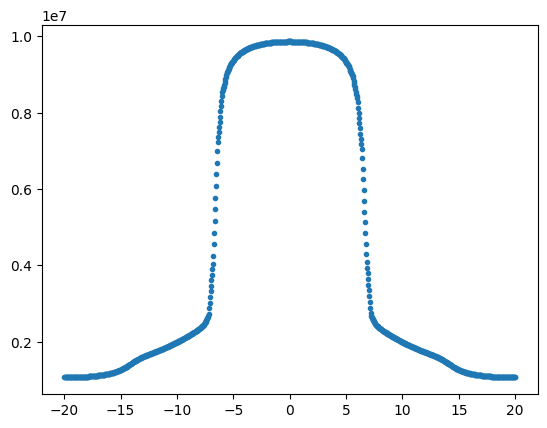

In [25]:
#Pyvista version

grid = pyvista.UnstructuredGrid(*create_vtk_mesh(W))
latentHeat = Function(W)
HeatExpression = Expression(SS.h(w),W.element.interpolation_points())
latentHeat.interpolate(HeatExpression)
grid.point_data["Solid Volume Fraction"] =latentHeat.x.array

ypos = -1e-10
a = [-20, ypos, 0]
b = [20, ypos, 0]
line = pyvista.Line(a, b, resolution=999)
line.clear_data()
print(line)

sampled = line.sample(grid, tolerance=1e-3)
x_coord =  sampled.points[:, 0]
samp_z_stress = sampled['Solid Volume Fraction'][:]

plt.plot(x_coord, samp_z_stress, '.', label='Z Component Stress')

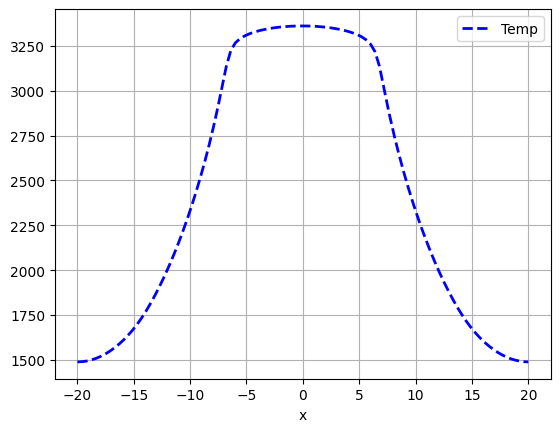

In [26]:
uh = Function(W)
#Heat Profile 
tol = 0.001 # Avoid hitting the outside of the domain
numpoints =1000
y = np.linspace(-20 + tol, 20 - tol, numpoints)
points = np.zeros((3, numpoints))
points[0,:] = y
points[1,:]=0
u_values = []
p_values = []

cells = []
points_on_proc = []
bb_tree = geometry.bb_tree(domain,domain.topology.dim)

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i))>0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)

qw_expr = fem.Expression(val, W_dummy.element.interpolation_points())
qw = fem.Function(W_dummy)
qw.interpolate(qw_expr)



u_values = w.eval(points_on_proc, cells)





fig = plt.figure()
#plt.plot(points_on_proc[:,1], 50*u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(points_on_proc[:,0], u_values, "b--", linewidth = 2, label="Temp")
plt.grid(True)
plt.xlabel("x")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")

In [27]:
import meshio
from pandas import value_counts
T_time = Function(W)
Values = []
Times = []
with meshio.xdmf.TimeSeriesReader("HeatMelting.xdmf") as reader:
    reader.read_points_cells()
    for i in range(reader.num_steps):
        time, Value, _ = reader.read_data(i)
        Values.append(Value["Temperature"][:,0])
        Times.append(time)

InternalEnergyCalc = fem.form(rho*SS.h(T_time)*dx)
ConvectionEnergyCalc = fem.form(h*(T_time-T_a)*ds(1))
RadiationEnergyCalc = fem.form(STBoltz*em*(T_time**4-T_a**4)*ds(1))
LaserEnergyCalc = fem.form(LaserOn*val*ds(1))

In [28]:
InternalEnergy =[]
ConvectionEnergy = []
RadiationEnergy = []
LaserEnergy = []
for Time,Value in zip(Times,Values):
    LaserOn.value = gaus(Time)
    T_time.x.array[:] = Value
    InternalEnergy.append(domain.comm.gather(fem.assemble_scalar(InternalEnergyCalc)))
    ConvectionEnergy.append(domain.comm.gather(fem.assemble_scalar(ConvectionEnergyCalc)))
    RadiationEnergy.append(domain.comm.gather(fem.assemble_scalar(RadiationEnergyCalc)))
    LaserEnergy.append(domain.comm.gather(fem.assemble_scalar(LaserEnergyCalc)))
LaserEnergy = np.array(LaserEnergy)
ConvectionEnergy = np.array(ConvectionEnergy)
InternalEnergy = np.array(InternalEnergy)
RadiationEnergy = np.array(RadiationEnergy)

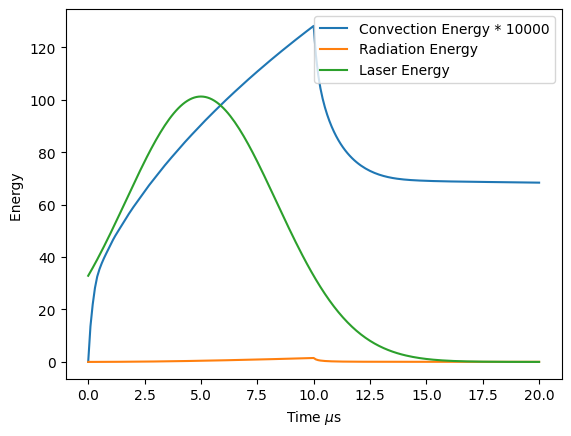

In [29]:
plt.figure()
#plt.plot(Times,(InternalEnergy-InternalEnergy[0]),label="Internal Energy")
plt.plot(Times,np.array(ConvectionEnergy)*10000,label="Convection Energy * 10000")
plt.plot(Times,RadiationEnergy,label="Radiation Energy")
plt.plot(Times,LaserEnergy,label="Laser Energy")

plt.xlabel("Time $\mu$s")
plt.ylabel("Energy ")
plt.legend()

Text(0.5, 0, 'Time $\\mu$s')

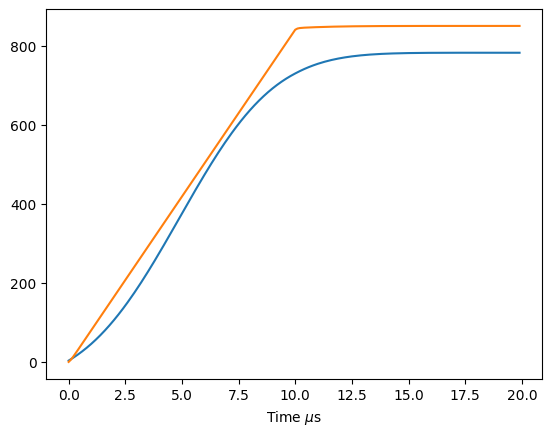

: 

In [33]:
import scipy.integrate
TotalEnergyEntering = LaserEnergy[:,0]-RadiationEnergy[:,0]-ConvectionEnergy[:,0]
plt.figure()
totalPower =scipy.integrate.cumulative_trapezoid(TotalEnergyEntering,Times)
#plt.plot(Times,(InternalEnergy-InternalEnergy[0]),label="Internal Energy")
plt.plot(Times[0:-1],totalPower,label="Energy Enertering")
plt.plot(Times[0:-1],(InternalEnergy[0:-1]-InternalEnergy[0])*dt,label="Energy Enertering")
plt.xlabel("Time $\mu$s")
